# Ungraded Lab: Effect of Compacted Images in Training

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Introduction_to_TensorFlow_for_Artificial_Intelligence_Machine_Learning_and_Deep_Learning/Week4/Labs/C1_W4_Lab_3_compacted_images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this notebook, you will see how reducing the target size of the generator images will affect the architecture and performance of your model. This is a useful technique in case you need to speed up your training or save compute resources. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

As before, start downloading the train and validation sets:

In [1]:
%%bash

mkdir data

# Download the training set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip -P ./data

# Download the validation set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip -P ./data

Then unzip them:

In [2]:
import zipfile
import os
from keras import Sequential, layers, Input, optimizers, utils, Model
import numpy as np
import random
import matplotlib.pyplot as plt

2024-06-10 17:24:16.088697: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Unzip training set
local_zip = './data/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/horse-or-human')

# Unzip validation set
local_zip = './data/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/validation-horse-or-human')

zip_ref.close()

Then define the directories containing the images:

In [4]:
# Directory with training horse pictures
train_horse_dir = os.path.join('./data/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./data/horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./data/validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./data/validation-horse-or-human/humans')

You can check that the directories are not empty and that the train set has more images than the validation set:

In [5]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse31-0.png', 'horse43-3.png', 'horse40-7.png', 'horse20-0.png', 'horse46-2.png', 'horse09-6.png', 'horse29-2.png', 'horse43-0.png', 'horse08-7.png', 'horse48-1.png']
TRAIN SET HUMANS: ['human17-20.png', 'human08-08.png', 'human14-03.png', 'human05-14.png', 'human16-04.png', 'human03-30.png', 'human03-16.png', 'human13-14.png', 'human14-29.png', 'human17-11.png']
VAL SET HORSES: ['horse5-103.png', 'horse2-441.png', 'horse2-383.png', 'horse2-201.png', 'horse1-000.png', 'horse2-011.png', 'horse4-548.png', 'horse2-582.png', 'horse5-181.png', 'horse4-599.png']
VAL SET HUMANS: ['valhuman04-13.png', 'valhuman02-01.png', 'valhuman03-00.png', 'valhuman05-02.png', 'valhuman03-11.png', 'valhuman05-15.png', 'valhuman05-16.png', 'valhuman04-15.png', 'valhuman05-27.png', 'valhuman01-16.png']


In [6]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


## Build the Model

The model will follow the same architecture as before but they key difference is in the `input_shape` parameter of the first `Conv2D` layer. Since you will be compacting the images later in the generator, you need to specify the expected image size here. So instead of 300x300 as in the previous two labs, you specify a smaller 150x150 array.

In [7]:
model = Sequential([Input(shape=(150, 150, 3)),
                    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
                    # This is the first convolution
                    layers.Conv2D(16, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The second convolution
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The third convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # # The fourth convolution (You can uncomment the 4th and 5th conv layers later to see the effect)
                    # layers.Conv2D(64, (3, 3), activation='relu'),
                    # layers.MaxPooling2D(2, 2),
                    # # The fifth convolution
                    # layers.Conv2D(64, (3, 3), activation='relu'),
                    # layers.MaxPooling2D(2, 2),
                    # Flatten the results to feed into a DNN
                    layers.Flatten(),
                    # 512 neuron hidden layer
                    layers.Dense(512, activation='relu'),
                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
                    layers.Dense(1, activation='sigmoid')])

2024-06-10 17:24:18.388310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1900 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


You can see the difference from previous models when you print the `model.summary()`. As expected, there will be less inputs to the `Dense` layer at the end of the model compared to the previous labs. This is because you used the same number of max pooling layers in your model. And since you have a smaller image to begin with (150 x 150), then the output after all the pooling layers will also be smaller.

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

You will use the same settings for training:

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will instantiate the data generators. As mentioned before, you will be compacting the image by specifying the `target_size` parameter. See the simple change below:

In [10]:
# All images will be rescaled by 1./255
scale = layers.Rescaling(scale=1. / 255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = utils.image_dataset_from_directory(directory='./data/horse-or-human/',  # This is the source directory for training images
                                                     image_size=(150, 150),  # All images will be resized to 300x300
                                                     # batch_size=128,
                                                     # Since we use binary_crossentropy loss, we need binary labels
                                                     label_mode='binary')

# Flow validation images in batches of 128 using validation_datagen generator
validation_generator = utils.image_dataset_from_directory(directory='./data/validation-horse-or-human/',  # This is the source directory for validation images
                                                          image_size=(150, 150),  # All images will be resized to 300x300
                                                          # batch_size=32,
                                                          # Since you use binary_crossentropy loss, you need binary labels
                                                          label_mode='binary')

train_generator = train_generator.map(lambda image, label: (scale(image), label))
validation_generator = validation_generator.map(lambda image, label: (scale(image), label))

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


### Training

Now you're ready to train and see the results. Note your observations about how fast the model trains and the accuracies you're getting in the train and validation sets.

In [11]:
history = model.fit(
                    train_generator,
                    # steps_per_epoch=8,  
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    # validation_steps=8
                    )

Epoch 1/15


I0000 00:00:1718061860.126152   36993 service.cc:145] XLA service 0x7f7e3c007540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718061860.126185   36993 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-10 17:24:20.151777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 17:24:20.422569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5840 - loss: 3.7564

I0000 00:00:1718061862.886072   36993 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6292 - loss: 1.9184 - val_accuracy: 0.5820 - val_loss: 1.6226
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8581 - loss: 0.3132 - val_accuracy: 0.9336 - val_loss: 0.2493
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8842 - loss: 0.4605 - val_accuracy: 0.9180 - val_loss: 0.2170
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9341 - loss: 0.1782 - val_accuracy: 0.8320 - val_loss: 1.2391
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9811 - loss: 0.0580 - val_accuracy: 0.8555 - val_loss: 0.5751
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9834 - loss: 0.0506 - val_accuracy: 0.5000 - val_loss: 5.8352
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9462 - loss: 0.4859 - val_accuracy: 0.7383 - val_loss: 2.0727
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9816 - loss: 0.0493 - val_accuracy: 0.8477 - val_loss: 1.

### Model Prediction

As usual, it is also good practice to try running your model over some handpicked images. See if you got better, worse, or the same performance as the previous lab.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

If you're using Safari and the cell above throws an error, you will need to upload the images(s) manually in their workspace.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [12]:
%%bash

mkdir ./data/images
wget -q https://content.nationalgeographic.com.es/medio/2022/12/12/caballo-1_c26bdfb7_221212154643_1280x720.jpg -O ./data/images/horse.jpg

In [13]:
# CODE BLOCK FOR OLD VERSIONS OF SAFARI

images = os.listdir("./data/images")

print(images)

for i in images:
    print()
    # predicting images
    path = './data/images/' + i
    img = utils.load_img(path, target_size=(150, 150))
    x = utils.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])

    if classes[0] > 0.5:
        print(i + " is a human")
    else:
        print(i + " is a horse")

['horse.jpg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
[4.113138e-07]
horse.jpg is a horse


### Visualizing Intermediate Representations

You can also look again at the intermediate representations. You will notice that the output at the last convolution layer is even more abstract because it contains fewer pixels than before.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


/tmp/ipykernel_36912/797168556.py:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_36912/797168556.py:44: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


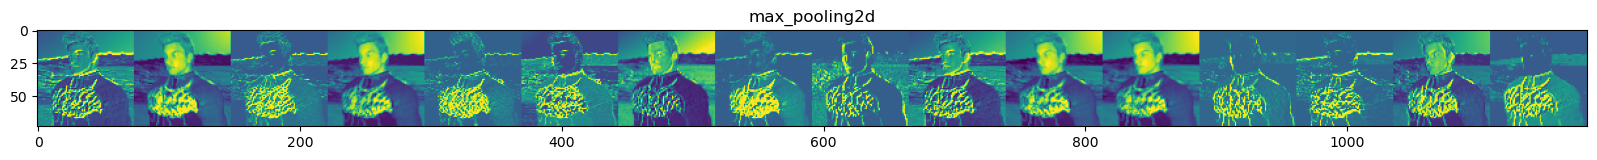

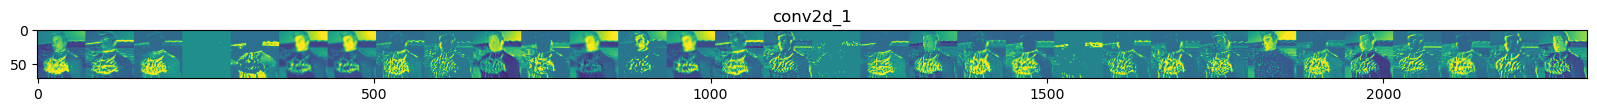

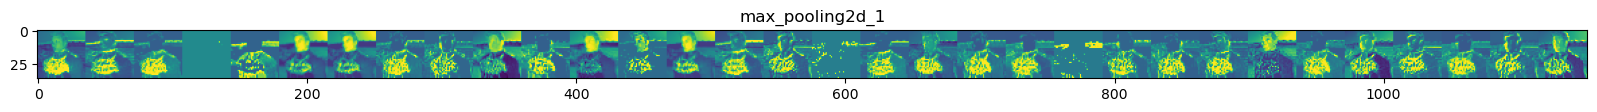

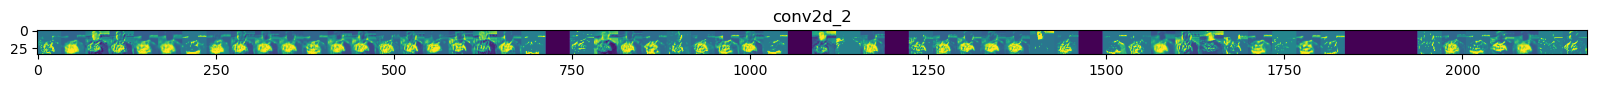

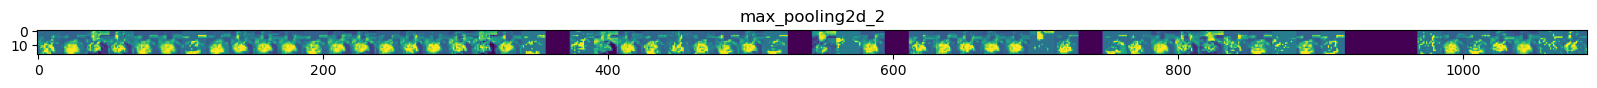

In [14]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputs=model.inputs, outputs=successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = utils.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = utils.img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        
        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean Up

Please run the following cell to terminate the kernel and free memory resources:

In [15]:
!rm -rf ./data

## Wrap Up

In this lab, you saw how compacting images affected your previous model. This is one technique to keep in mind especially when you are still in the exploratory phase of your own projects. You can see if a smaller model behaves just as well as a large model so you can have faster training. You also saw how easy it is to customize your images for this adjustment in size by simply changing a parameter in the `ImageDataGenerator` class.